# Classification of AD vs MCI vs NC Using the ResNet Pre-Trained Model

## Import the packages

In [ ]:
! sudo apt-get update
! pip install -r requirements.txt
! sudo apt install libgl1 -y

#! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118



Hit:1 http://security.ubuntu.com/ubuntu noble-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu noble InRelease
Hit:3 http://archive.ubuntu.com/ubuntu noble-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu noble-backports InRelease
Reading package lists... Done
Defaulting to user installation because normal site-packages is not writeable
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1 is already the newest version (1.7.0-1build1).
0 upgraded, 0 newly installed, 0 to remove and 46 not upgraded.


In [2]:
import os
import sys
import numpy as np
import pandas as pd
import torch
from torch import nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
from torchinfo import summary
import shutil
import data_manager as DM
# import torchvision.models as models
import torchvision.models.video as models
from torchvision.models.video import R3D_18_Weights
import data_setup, engine
from helper_functions import plot_loss_curves
from data_setup import create_dataloaders
import engine
from torchvision.transforms.functional import InterpolationMode
from torch.utils.data import DataLoader
from helper_functions import plot_loss_curves, plot_roc_auc
import torchio as tio
from torchvision.models.video import R3D_18_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau
from monai.networks.nets import DenseNet121
from torch.optim.lr_scheduler import StepLR
from monai.transforms import Compose, Resize, ScaleIntensity, NormalizeIntensity, RandFlip
import random
from monai.bundle import download, load
from transformers import pipeline, AutoImageProcessor, AutoModelForImageClassification

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Add the parrent path to current path because data is there

In [3]:
current_path = os.getcwd()
parrent_path = os.path.abspath(os.path.join(current_path, '..'))
sys.path.append(parrent_path)

## Manage data:

✔ Read subject IDs from each sheet in Subject list.xlsx.

✔ Create Data/AD, Data/MCI, Data/NC folders.

✔ Find std_T1.nii for each subject inside ADNI/{subject_id}/.

✔ Copy & renames the file to Data/{category}/{subject_id}.nii.

In [4]:
categories = ["AD", "MCI", "NC"]
excel_file = "../Subject_list.xlsx"
source_root = "ADNI"
destination_root = "Data"
if os.path.join(destination_root):
   os.system('rm -r Data')
source_dir = "../"
image_type = "std_T1"
DM.copy_data(image_type, excel_file,source_root,source_dir, destination_root,categories)
image_type = "SUV"
DM.copy_data(image_type, excel_file,source_root,source_dir, destination_root,categories)


Copied: ../AD/ADNI/002_S_5018/std_T1.nii → Data/train/AD/002_S_5018std_T1.nii
Copied: ../AD/ADNI/003_S_1059/std_T1.nii → Data/train/AD/003_S_1059std_T1.nii
Copied: ../AD/ADNI/003_S_1257/std_T1.nii → Data/train/AD/003_S_1257std_T1.nii
Copied: ../AD/ADNI/003_S_4136/std_T1.nii → Data/train/AD/003_S_4136std_T1.nii
Copied: ../AD/ADNI/003_S_4152/std_T1.nii → Data/train/AD/003_S_4152std_T1.nii
Copied: ../AD/ADNI/003_S_4373/std_T1.nii → Data/train/AD/003_S_4373std_T1.nii
Copied: ../AD/ADNI/003_S_4892/std_T1.nii → Data/train/AD/003_S_4892std_T1.nii
Copied: ../AD/ADNI/003_S_5165/std_T1.nii → Data/train/AD/003_S_5165std_T1.nii
Copied: ../AD/ADNI/003_S_5187/std_T1.nii → Data/train/AD/003_S_5187std_T1.nii
Copied: ../AD/ADNI/005_S_0221/std_T1.nii → Data/train/AD/005_S_0221std_T1.nii
Copied: ../AD/ADNI/005_S_0929/std_T1.nii → Data/train/AD/005_S_0929std_T1.nii
Copied: ../AD/ADNI/005_S_1341/std_T1.nii → Data/train/AD/005_S_1341std_T1.nii
Copied: ../AD/ADNI/005_S_4707/std_T1.nii → Data/train/AD/005_S_4

How many subjects do we have in each group?

In [5]:
data_root = "Data"

for c in categories:
    path_train = os.path.join(data_root, 'train', c)
    path_test = os.path.join(data_root, 'test', c)

    num_train_files = len(os.listdir(path_train))
    print(f"{c} train: {num_train_files} files")

    num_test_files = len(os.listdir(path_test))
    print(f"{c} test: {num_test_files} files")


AD train: 308 files
AD test: 60 files
MCI train: 324 files
MCI test: 64 files
NC train: 402 files
NC test: 80 files


## Classification Model

### MONAI DenseNET121

In [6]:
img_size = 64

# MRI subnetwork
mri_model = DenseNet121(
    spatial_dims=3,
    in_channels=1,           # Only MRI
    out_channels=1024        # Feature vector
)

# PET subnetwork
pet_model = DenseNet121(
    spatial_dims=3,
    in_channels=1,           # Only PET
    out_channels=1024        # Feature vector
)

# Late Fusion Classifier
class LateFusionModel(nn.Module):
    def __init__(self, mri_model, pet_model, num_classes):
        super().__init__()
        self.mri_model = mri_model
        self.pet_model = pet_model
        self.classifier = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.6),  # Increase dropout rate
            nn.Linear(in_features=2048, out_features=128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.6),
            nn.Linear(128, num_classes)
        )


    def forward(self, x):
        mri, pet = x[:, 0:1], x[:, 1:2]  # Split channels: [B, 1, D, H, W]
        mri_feat = self.mri_model(mri)
        pet_feat = self.pet_model(pet)
        combined = torch.cat([mri_feat, pet_feat], dim=1)
        return self.classifier(combined)

# Instantiate late fusion model
Monai3d = LateFusionModel(mri_model, pet_model, num_classes=3)

# Print model summary
summary(model=Monai3d,
        input_size=(1, 2, img_size, img_size, img_size),  # (batch_size, channels, D, H, W)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
LateFusionModel (LateFusionModel)                  [1, 2, 64, 64, 64]   [1, 3]               --                   True
├─DenseNet121 (mri_model)                          [1, 1, 64, 64, 64]   [1, 1024]            --                   True
│    └─Sequential (features)                       [1, 1, 64, 64, 64]   [1, 1024, 2, 2, 2]   --                   True
│    │    └─Conv3d (conv0)                         [1, 1, 64, 64, 64]   [1, 64, 32, 32, 32]  21,952               True
│    │    └─BatchNorm3d (norm0)                    [1, 64, 32, 32, 32]  [1, 64, 32, 32, 32]  128                  True
│    │    └─ReLU (relu0)                           [1, 64, 32, 32, 32]  [1, 64, 32, 32, 32]  --                   --
│    │    └─MaxPool3d (pool0)                      [1, 64, 32, 32, 32]  [1, 64, 16, 16, 16]  --                   --
│    │    └─_DenseBlock (denseblock1)          

## Data loader: Prepare the data for model training and testing

 
Class names: ['MCI', 'NC', 'AD']
Number of classes: 3
 
Number of training samples: 1034
Number of testing samples: 102
torch.Size([64, 2, 64, 64, 64]) torch.Size([64])


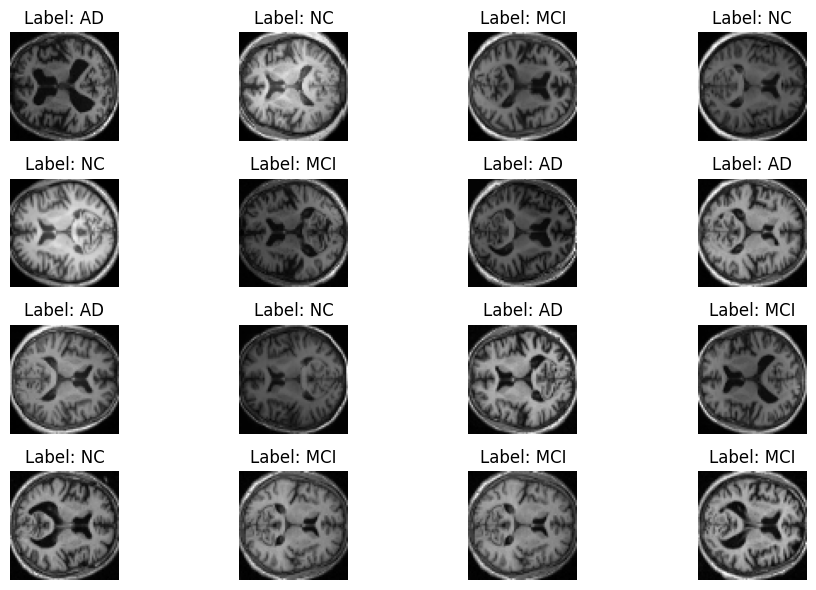

In [7]:
# Define global params
batch_size = 64
random.seed(20)

# Base transform
transform = Compose([
    Resize(spatial_size=(img_size, img_size, img_size), mode='trilinear'),
    lambda x: (x - x.min()) / (x.max() - x.min() + 1e-5),
])

# Your custom intensity adjustment function
def random_intensity_adjust(img):
    factor = random.uniform(0.8, 1.2)
    return img * factor

augmentation_transform = Compose([
    Resize(spatial_size=(img_size, img_size, img_size), mode='trilinear'),
    # transforms.RandomHorizontalFlip(p=1),
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomRotation(degrees=10),  # Add random rotation
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    lambda x: (x - x.min()) / (x.max() - x.min() + 1e-5),  # Normalize
    lambda x: random_intensity_adjust(x)
])


# Prepare paths
train_data_path = os.path.join(data_root, "train")
test_data_path = os.path.join(data_root, "test")

# Load DataLoaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_data_path,
    test_dir=test_data_path,
    transform=transform,
    batch_size=batch_size,
    augmentation_transform=augmentation_transform
)

# Print info
print(' ')
print(f"Class names: {class_names}")
print(f"Number of classes: {len(class_names)}")
print(' ')
print("Number of training samples:", len(train_dataloader.dataset))
print("Number of testing samples:", len(test_dataloader.dataset))


# Visualize samples
image_batch, label_batch = next(iter(train_dataloader))
print(image_batch.shape, label_batch.shape)

# Randomly sample n PET middle slices
num_images = 16
batch_size = image_batch.shape[0]
random_indices = torch.randint(0, batch_size, (num_images,))
mid_slice_idx = image_batch.shape[4] // 2  # Depth index

fig, axes = plt.subplots(4, 4, figsize=(10, 6))
for i, ax in enumerate(axes.flat):
    idx = random_indices[i]
    img = image_batch[idx, 1, :, :, mid_slice_idx].detach().cpu().numpy()  # PET slice
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {class_names[label_batch[idx].item()]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


## TRAIN AND TEST

In [8]:
# Check the device
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Working on device: {device}")

# Model
model = Monai3d

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
# loss_fn = torch.nn.NLLLoss()
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=5, gamma=0.6)

# Train the classifier head of the pretrained ViT feature extractor model
torch.manual_seed(21)
torch.cuda.manual_seed(21)

model_results = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=30,
    device=device,
    scheduler = scheduler
)

Working on device: cuda


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1119 | train_acc: 0.3781 | test_loss: 12.0808 | test_acc: 0.3922
class_0_sensitivity: 0.0000
class_0_specificity: 1.0000
class_1_sensitivity: 1.0000
class_1_specificity: 0.0000
class_2_sensitivity: 0.0000
class_2_specificity: 1.0000
weighted_f1_score: 0.2209


/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 2 | train_loss: 1.0704 | train_acc: 0.4381 | test_loss: 1.8933 | test_acc: 0.4510
class_0_sensitivity: 0.2812
class_0_specificity: 0.9000
class_1_sensitivity: 0.9250
class_1_specificity: 0.2419
class_2_sensitivity: 0.0000
class_2_specificity: 0.9722
weighted_f1_score: 0.3517
Epoch: 3 | train_loss: 1.0030 | train_acc: 0.4826 | test_loss: 1.3351 | test_acc: 0.4118
class_0_sensitivity: 0.0312
class_0_specificity: 1.0000
class_1_sensitivity: 1.0000
class_1_specificity: 0.0323
class_2_sensitivity: 0.0333
class_2_specificity: 1.0000
weighted_f1_score: 0.2621
Epoch: 4 | train_loss: 0.9424 | train_acc: 0.5880 | test_loss: 1.2007 | test_acc: 0.4412
class_0_sensitivity: 0.0312
class_0_specificity: 1.0000
class_1_sensitivity: 0.9750
class_1_specificity: 0.1290
class_2_sensitivity: 0.1667
class_2_specificity: 0.9583
weighted_f1_score: 0.3264
Epoch: 5 | train_loss: 0.9961 | train_acc: 0.5435 | test_loss: 1.4603 | test_acc: 0.4118
class_0_sensitivity: 0.0000
class_0_specificity: 1.0000
class_

/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6 | train_loss: 0.8913 | train_acc: 0.5667 | test_loss: 1.0370 | test_acc: 0.5588
class_0_sensitivity: 0.0000
class_0_specificity: 1.0000
class_1_sensitivity: 0.9750
class_1_specificity: 0.3871
class_2_sensitivity: 0.6000
class_2_specificity: 0.9028
weighted_f1_score: 0.4540


/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7 | train_loss: 0.7794 | train_acc: 0.6383 | test_loss: 1.0603 | test_acc: 0.5490
class_0_sensitivity: 0.3438
class_0_specificity: 0.8857
class_1_sensitivity: 0.9500
class_1_specificity: 0.4194
class_2_sensitivity: 0.2333
class_2_specificity: 0.9722
weighted_f1_score: 0.5024
Epoch: 8 | train_loss: 0.7425 | train_acc: 0.6586 | test_loss: 1.0576 | test_acc: 0.4510
class_0_sensitivity: 0.9688
class_0_specificity: 0.2286
class_1_sensitivity: 0.3500
class_1_specificity: 0.9677
class_2_sensitivity: 0.0333
class_2_specificity: 1.0000
weighted_f1_score: 0.3813
Epoch: 9 | train_loss: 0.8147 | train_acc: 0.6064 | test_loss: 0.9735 | test_acc: 0.5294
class_0_sensitivity: 0.0000
class_0_specificity: 0.9714
class_1_sensitivity: 0.9750
class_1_specificity: 0.3710
class_2_sensitivity: 0.5000
class_2_specificity: 0.9028
weighted_f1_score: 0.4289
Epoch: 10 | train_loss: 0.7592 | train_acc: 0.6547 | test_loss: 0.8295 | test_acc: 0.6078
class_0_sensitivity: 0.0312
class_0_specificity: 1.0000
class

## PLOT

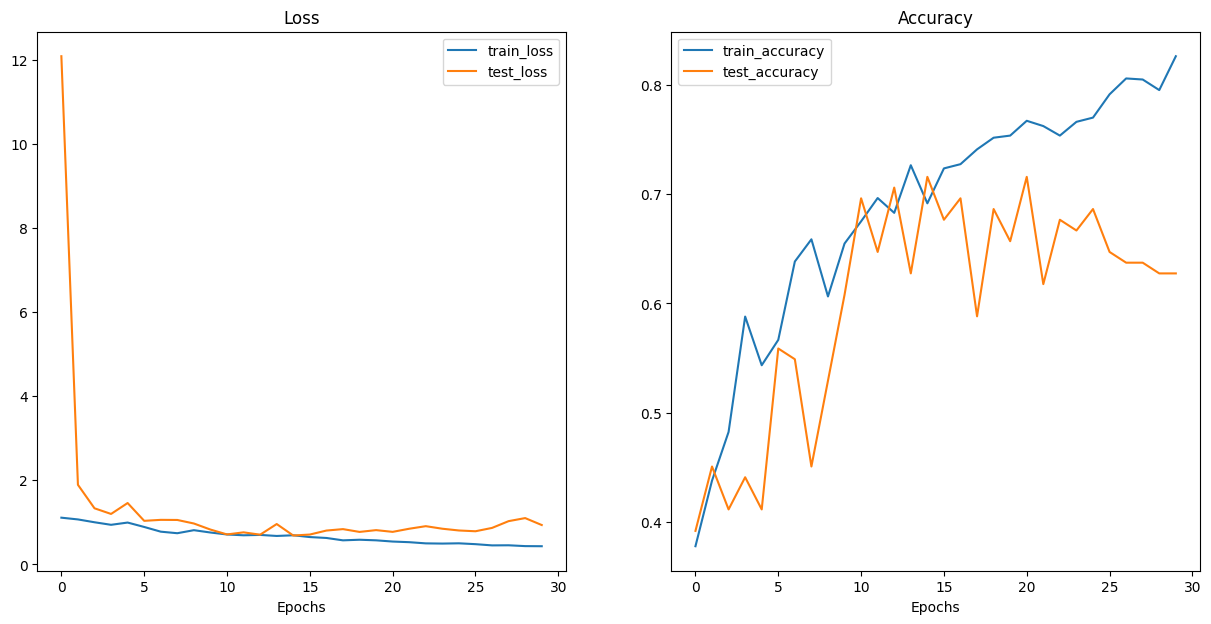

In [9]:
plot_loss_curves(model_results)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Step 1: Collect predictions and ground-truth labels
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in train_dataloader:
        inputs, labels = batch  # Unpack if batch is a tuple
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)  # <--- You were missing this line
        probs = torch.softmax(outputs, dim=1)  # Get class probabilities
        
        all_preds.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())


# Convert to numpy arrays
y_score = np.concatenate(all_preds, axis=0)      # shape: (num_samples, num_classes)
y_true = np.concatenate(all_labels, axis=0)      # shape: (num_samples,)

# Step 2: Binarize the labels for ROC computation
n_classes = y_score.shape[1]
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Step 3: Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 4 (Optional): Compute micro-average and macro-average
# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Step 5: Plot all ROC curves
plt.figure(figsize=(10, 8))

# Plot per-class ROC
colors = cycle(['blue', 'green', 'red', 'orange', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot micro/macro average ROC
# plt.plot(fpr["micro"], tpr["micro"], linestyle='--', color='deeppink',
#          label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})', linewidth=2)

# plt.plot(fpr["macro"], tpr["macro"], linestyle='--', color='navy',
#          label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})', linewidth=2)

# Plot diagonal line for random guess
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Final touches
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('Multi-class ROC Curve', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')



## Save the model

In [ ]:
def save_model(model, target_dir, model_name):
    os.makedirs(target_dir, exist_ok=True)
    save_path = os.path.join(target_dir, model_name)
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

save_model(model=model,
            target_dir="models",
            model_name="MONAI3D_AD_MCI_NC.pth")

## Load the model

In [14]:
import torch
from torch.utils.data import DataLoader
from data_setup import MultiModalSeparateNiiDataset

torch.manual_seed(21)
torch.cuda.manual_seed_all(21)
model.eval()

valid_dataset = MultiModalSeparateNiiDataset("Data/valid", categories, transform)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True)

test_loss, test_acc, metrics, classification_summary = engine.test_step(
    model=model,
    dataloader=valid_loader,
    loss_fn=loss_fn,
    device=device
)

print("Test Accuracy:", test_acc)
for class_index, sensitivity in metrics.items():
    print(f"Class {class_index}: Sensitivity = {sensitivity:.4f}")


Test Accuracy: 0.27450980392156865
Class class_0_sensitivity: Sensitivity = 0.2667
Class class_0_specificity: Sensitivity = 0.7222
Class class_1_sensitivity: Sensitivity = 0.5000
Class class_1_specificity: Sensitivity = 0.5000
Class class_2_sensitivity: Sensitivity = 0.1000
Class class_2_specificity: Sensitivity = 0.6935
Class weighted_f1_score: Sensitivity = 0.2519
